In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir(os.path.abspath(".."))

In [3]:
df_annotations = pd.read_excel("data/annotations_2.xlsx")

In [4]:
PC_Num, Part_Num = 1536, 1

### Obtain input data

In [5]:
from src.dataload import load_audio_data

data, time, sr = load_audio_data(df_annotations, PC_Num, Part_Num)

df_input = pd.DataFrame(data = np.stack([time,data]).T, columns = ['Time','Data'])

In [6]:
df_input

,Time,Data
0,0.000000,0.020660
1,0.000063,0.026672
2,0.000125,0.021027
3,0.000188,0.013885
4,0.000250,0.009399
...,...,...
4646905,290.431562,-0.000854
4646906,290.431625,-0.000244
4646907,290.431688,-0.000244
4646908,290.431750,-0.000275


### Target Data

In [8]:
from src.dataload import audio_select_mean_vote
from src.emotion_translation import ekman_emotion

# MEAN VOTE
df = audio_select_mean_vote(df_annotations, PC_Num, Part_Num)

# EKMAN
df['Emotion'] = df.apply(lambda row : ekman_emotion(row['Valence'], row['Arousal'], row['Dominance']), axis = 1)

In [16]:
df[df['Time'] < 1]

,Time,Valence,Arousal,Dominance,Emotion
0,0.040000,-0.004000,0.388333,-0.002500,disgust
1,0.041000,0.126667,0.388333,-0.002000,disgust
2,0.045000,0.126667,0.388333,-0.001667,disgust
3,0.053780,0.126667,0.388333,-0.001667,disgust
4,0.056595,0.126667,0.388333,-0.001667,disgust
...,...,...,...,...,...
466,0.986410,8.428333,15.143333,12.661667,surprise
467,0.986480,8.428333,15.143333,12.661667,surprise
468,0.986750,8.428333,15.143333,12.661667,surprise
469,0.986860,8.428333,15.143333,12.661667,surprise


In [17]:
df[df['Time'] < 1].set_index('Time').drop_duplicates()

,Valence,Arousal,Dominance,Emotion
Time,,,,
0.04000,-0.004000,0.388333,-0.002500,disgust
0.04100,0.126667,0.388333,-0.002000,disgust
0.04500,0.126667,0.388333,-0.001667,disgust
0.41144,0.126667,0.486667,-0.001667,disgust
0.45160,0.126667,0.811667,-0.001667,disgust
0.49088,0.126667,1.463333,-0.001667,disgust
0.55100,0.126667,1.788333,-0.001667,disgust
0.55500,0.126667,1.788333,0.161667,disgust
0.59237,0.126667,2.048333,0.161667,disgust


In [15]:
len(df[df['Time'] < 1].set_index('Time').drop_duplicates())

52

In [9]:
df

,Time,Valence,Arousal,Dominance,Emotion
0,0.040000,-0.004000,0.388333,-0.002500,disgust
1,0.041000,0.126667,0.388333,-0.002000,disgust
2,0.045000,0.126667,0.388333,-0.001667,disgust
3,0.053780,0.126667,0.388333,-0.001667,disgust
4,0.056595,0.126667,0.388333,-0.001667,disgust
...,...,...,...,...,...
142789,290.519400,21.526667,38.025000,42.795000,joy
142790,290.523900,21.526667,38.025000,42.795000,joy
142791,290.525100,21.526667,38.025000,42.795000,joy
142792,290.526900,21.526667,38.025000,42.795000,joy


### Create input - target

In [18]:
time_index = pd.concat([df['Time'],df_input['Time']], ignore_index = True).drop_duplicates().sort_values().reset_index(drop = True)

In [20]:
df_train = pd.merge(time_index, df_input, how = 'left', on = 'Time')
df_train = pd.merge(df_train, df, how = 'left', on = 'Time')

df_train = df_train.fillna(method='ffill').fillna(method='bfill')

In [21]:
df_train

,Time,Data,Valence,Arousal,Dominance,Emotion
0,0.000000,0.020660,-0.004000,0.388333,-0.0025,disgust
1,0.000063,0.026672,-0.004000,0.388333,-0.0025,disgust
2,0.000125,0.021027,-0.004000,0.388333,-0.0025,disgust
3,0.000188,0.013885,-0.004000,0.388333,-0.0025,disgust
4,0.000250,0.009399,-0.004000,0.388333,-0.0025,disgust
...,...,...,...,...,...,...
4759048,290.519400,-0.000214,21.526667,38.025000,42.7950,joy
4759049,290.523900,-0.000214,21.526667,38.025000,42.7950,joy
4759050,290.525100,-0.000214,21.526667,38.025000,42.7950,joy
4759051,290.526900,-0.000214,21.526667,38.025000,42.7950,joy


In [22]:
frame_duration = 0.1

df_train['Frame'] = np.floor(df_train['Time'] / frame_duration)
df_train['Frame'] = df_train['Frame'].astype(int)

In [23]:
from src.feature_extraction import extract_classical_features

X, Y = [], []
for frame in df_train['Frame'].unique():
    
    df_frame = df_train[df_train['Frame'] == frame]
    
    feature = extract_classical_features(df_frame['Data'].values, sample_rate = sr)
    emotion = df_frame.groupby('Emotion').count().sort_values(by = 'Time', ascending = False).reset_index().loc[0,'Emotion']
    
    X.append(feature)
    Y.append(emotion)
    
    if frame % 100 == 0:
        print(frame)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.069458,0.366753,0.316715,0.322348,0.443468,0.555132,0.731817,0.948012,0.812930,0.527895,...,0.000200,0.000235,0.000229,0.000295,0.000301,0.000201,0.000138,0.000157,0.000125,disgust
1,0.088257,0.741825,0.561201,0.467461,0.619171,0.695684,0.810005,0.771840,0.609848,0.496793,...,0.000191,0.000159,0.000176,0.000156,0.000313,0.000171,0.000203,0.000123,0.000133,disgust
2,0.047241,0.869963,0.713784,0.548782,0.537595,0.563273,0.699371,0.743995,0.593558,0.465164,...,0.000143,0.000124,0.000146,0.000107,0.000148,0.000121,0.000132,0.000072,0.000079,disgust
3,0.038696,0.926967,0.601852,0.481066,0.553190,0.552200,0.580873,0.654273,0.553368,0.499143,...,0.000031,0.000046,0.000047,0.000030,0.000035,0.000057,0.000070,0.000046,0.000043,disgust
4,0.041138,0.444917,0.498491,0.816066,0.706766,0.241607,0.186083,0.235132,0.254621,0.212060,...,0.003629,0.006338,0.005521,0.005156,0.003971,0.003389,0.003790,0.003741,0.002903,disgust


### Pre-Process

In [14]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
from sklearn.model_selection import train_test_split

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162), (2179, 4), (727, 162), (727, 4))

In [19]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162), (2179, 4), (727, 162), (727, 4))

In [20]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162, 1), (2179, 4), (727, 162, 1), (727, 4))

### Creación del modelo

In [27]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

In [28]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
35/35 [==============================] - 3s 68ms/step - loss: 0.4064 - accuracy: 0.9169 - val_loss: 0.3172 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2784 - accuracy: 0.9449 - val_loss: 0.2849 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2873 - accuracy: 0.9436 - val_loss: 0.2793 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2611 - accuracy: 0.9454 - val_loss: 0.2965 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2694 - accuracy: 0.9454 - val_loss: 0.2764 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2718 - accuracy: 0.9454 - val_loss: 0.2666 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2

23/23 [==============================] - 0s 10ms/step - loss: 0.2663 - accuracy: 0.9354
Accuracy of our model on test data :  93.5350775718689 %


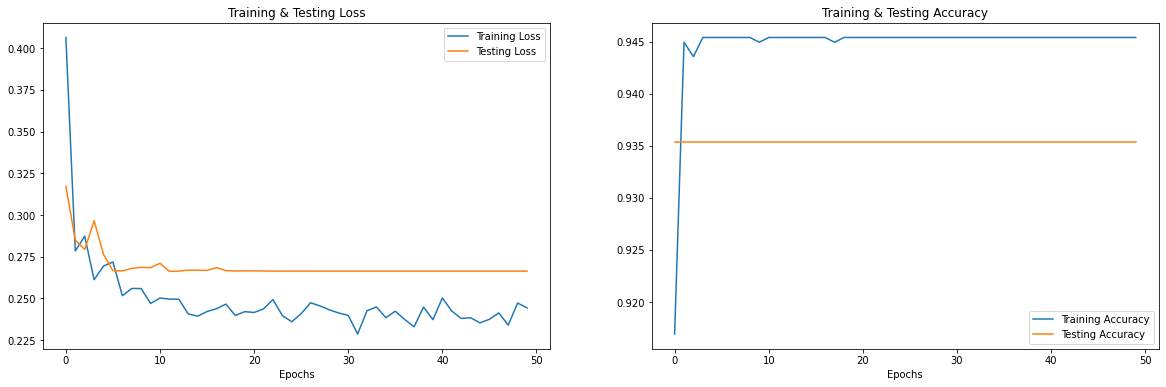

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

23/23 [==============================] - 0s 10ms/step


In [32]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,joy,joy
1,joy,joy
2,joy,joy
3,joy,joy
4,joy,joy
5,joy,joy
6,joy,joy
7,joy,joy
8,joy,joy
9,joy,surprise


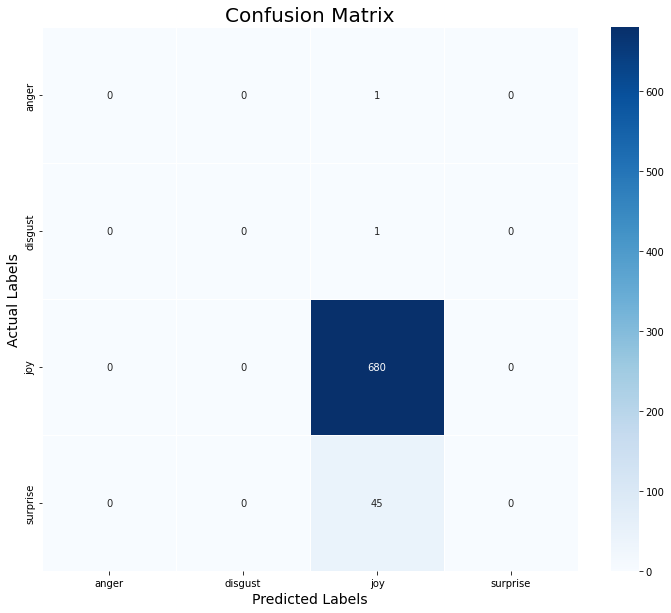

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
     disgust       0.00      0.00      0.00         1
         joy       0.94      1.00      0.97       680
    surprise       0.00      0.00      0.00        45

    accuracy                           0.94       727
   macro avg       0.23      0.25      0.24       727
weighted avg       0.87      0.94      0.90       727

